In [1]:
# from google.colab import files
# uploaded = files.upload()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
#Importing Required Libraries LSTM
import pandas as pd
import numpy as np
import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.layers.core import Dense, Activation, Dropout
# from keras.layers.recurrent import LSTM
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Conv1D
import time

from sklearn.decomposition import PCA

In [4]:
from pyspark.sql import functions as sf

In [5]:
import joblib

In [6]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [7]:
from pyspark.sql import SparkSession
# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Read JSON file into DataFrame
json_file_path = "/home/vannini/harpia/flight_data.json"
df = spark.read.json(json_file_path)


df_s = df.select(
    "id",
    "Type",
    "error",
    sf.explode("data").alias("data")
).select(
    "id",
    "Type",
    "error",
    sf.col("data.roll").alias("roll"),
    sf.col("data.pitch").alias("pitch"),
    sf.col("data.yaw").alias("yaw"),
    sf.col("data.heading").alias("heading"),
    sf.col("data.rollRate").alias("rollRate"),
    sf.col("data.pitchRate").alias("pitchRate"),
    sf.col("data.yawRate").alias("yawRate"),
    sf.col("data.groundSpeed").alias("groundSpeed"),
    sf.col("data.climbRate").alias("climbRate"),
    sf.col("data.altitudeRelative").alias("altitudeRelative"),
    sf.col("data.throttlePct").alias("throttlePct")
)
# df_s.printSchema()
# Print the DataFrame
# df.show()

/home/vannini/.local/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [8]:
# Read JSON file into DataFrame
json_file_path = "/home/vannini/harpia/flight_data_gauss_mild.json"
df = spark.read.json(json_file_path)


df_m = df.select(
    "id",
    "Type",
    "error",
    sf.explode("data").alias("data")
).select(
    "id",
    "Type",
    "error",
    sf.col("data.roll").alias("roll"),
    sf.col("data.pitch").alias("pitch"),
    sf.col("data.yaw").alias("yaw"),
    sf.col("data.heading").alias("heading"),
    sf.col("data.rollRate").alias("rollRate"),
    sf.col("data.pitchRate").alias("pitchRate"),
    sf.col("data.yawRate").alias("yawRate"),
    sf.col("data.groundSpeed").alias("groundSpeed"),
    sf.col("data.climbRate").alias("climbRate"),
    sf.col("data.altitudeRelative").alias("altitudeRelative"),
    sf.col("data.throttlePct").alias("throttlePct")
)


In [9]:
# Read JSON file into DataFrame
json_file_path = "/home/vannini/harpia/flight_data_gauss_noise.json"
df = spark.read.json(json_file_path)


df_n = df.select(
    "id",
    "Type",
    "error",
    sf.explode("data").alias("data")
).select(
    "id",
    "Type",
    "error",
    sf.col("data.roll").alias("roll"),
    sf.col("data.pitch").alias("pitch"),
    sf.col("data.yaw").alias("yaw"),
    sf.col("data.heading").alias("heading"),
    sf.col("data.rollRate").alias("rollRate"),
    sf.col("data.pitchRate").alias("pitchRate"),
    sf.col("data.yawRate").alias("yawRate"),
    sf.col("data.groundSpeed").alias("groundSpeed"),
    sf.col("data.climbRate").alias("climbRate"),
    sf.col("data.altitudeRelative").alias("altitudeRelative"),
    sf.col("data.throttlePct").alias("throttlePct")
)

In [10]:
df_n = df_n.withColumn("tag", sf.lit("noise"))
df_m = df_m.withColumn("tag", sf.lit("mild"))
df_s = df_s.withColumn("tag", sf.when(sf.col("error"),sf.lit("error")).otherwise(sf.lit("normal")))\
           .where(~sf.col("error"))

In [11]:
df_s = df_s.unionByName(df_n).unionByName(df_m)

In [12]:
df_s.show()

+---+-------------------+-----+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-----------+------+
| id|               Type|error|                roll|               pitch|                 yaw|          heading|            rollRate|           pitchRate|             yawRate|         groundSpeed|          climbRate|   altitudeRelative|throttlePct|   tag|
+---+-------------------+-----+--------------------+--------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-----------+------+
|  6|Takeoff and landing|false|-0.00730416923761...|0.002814507810398...|-0.05884323269128...|93.37000274658203|-3.47199966199696...|0.004307299852371216|-0.00113446451723...|0.026676926761865616|-0.1743333637714386|-0.7960000038146

In [13]:
df_s.groupBy('id').count().groupBy().avg().show()

+------------------+-----------------+
|           avg(id)|       avg(count)|
+------------------+-----------------+
|241.58227848101265|151.5645569620253|
+------------------+-----------------+



In [14]:
def info(df):
  print(df.info(verbose=True))
  return None

In [15]:
def nulls_qtd(df):
  print(df.isna().sum())
  return None

In [16]:
def describe(df, perc, drop_list = None):
  if drop_list == None:
    df.select_dtypes(include='number').describe(percentiles = perc)
  else:
    df.select_dtypes(include='number').drop(drop_list, axis=1).describe(percentiles = perc)
  return None

In [17]:
def shape(df):
  # DataFrame shape
  print(f'Rows: {df.shape[0]}\n   \nColumns: {df.shape[1]}')
  return None

In [18]:
def select_columns(df, columns_names_list):
  df_new = df[columns_names_list]
  return df_new

In [19]:
def split_train_test(X, y, strat, perc = 0.25):
  """
  X: x's variables
  y: target variable (system response)
  perc: test data percentage (decimal value; default = 0.2 = 20% of data)
  """
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=strat)

  # Resets all DFs indexes
  X_train.reset_index(drop = True, inplace = True)
  X_test.reset_index(drop = True, inplace = True)
  y_train.reset_index(drop = True, inplace = True)
  y_test.reset_index(drop = True, inplace = True)

  return X_train, X_test, y_train, y_test

# PCA Vizualization

In [20]:
df = df_s.toPandas()
df.head()

,id,Type,error,roll,pitch,yaw,heading,rollRate,pitchRate,yawRate,groundSpeed,climbRate,altitudeRelative,throttlePct,tag
0,6,Takeoff and landing,False,-0.007304,0.002815,-0.058843,93.370003,-0.000347,0.004307,-0.001134,0.026677,-0.174333,-0.796,0.0,normal
1,6,Takeoff and landing,False,-0.007304,0.002815,-0.058843,93.370003,-0.000347,0.004307,-0.001134,0.026677,-0.174333,-0.796,0.0,normal
2,6,Takeoff and landing,False,-0.007304,0.002815,-0.058843,93.370003,-0.000347,0.004307,-0.001134,0.026677,-0.174333,-0.796,0.0,normal
3,6,Takeoff and landing,False,-0.007304,0.002815,-0.058843,93.370003,-0.000347,0.004307,-0.001134,0.026677,-0.174333,-0.796,0.0,normal
4,6,Takeoff and landing,False,-0.007304,0.002815,-0.058843,93.370003,-0.000347,0.004307,-0.001134,0.026677,-0.174333,-0.796,0.0,normal


In [21]:
#Preparing the data for LSTM model
data_pca = df.drop(columns=['id','Type', 'tag','error' ]).fillna(0)
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_pca)
data_pca = pd.DataFrame(np_scaled, columns=data_pca.columns)
data_pca

,roll,pitch,yaw,heading,rollRate,pitchRate,yawRate,groundSpeed,climbRate,altitudeRelative,throttlePct
0,0.383349,0.384093,0.228692,-0.209936,0.421612,0.421936,0.422812,0.027562,-0.243295,-0.419798,-0.744202
1,0.383349,0.384093,0.228692,-0.209936,0.421612,0.421936,0.422812,0.027562,-0.243295,-0.419798,-0.744202
2,0.383349,0.384093,0.228692,-0.209936,0.421612,0.421936,0.422812,0.027562,-0.243295,-0.419798,-0.744202
3,0.383349,0.384093,0.228692,-0.209936,0.421612,0.421936,0.422812,0.027562,-0.243295,-0.419798,-0.744202
4,0.383349,0.384093,0.228692,-0.209936,0.421612,0.421936,0.422812,0.027562,-0.243295,-0.419798,-0.744202
...,...,...,...,...,...,...,...,...,...,...,...
59863,-2.425481,2.284906,-0.298293,-1.105874,-2.661572,-4.257497,1.259549,1.373845,0.095632,-0.172919,0.209465
59864,-3.474225,-2.293175,-1.789402,-0.895438,-1.174061,-1.721734,-1.635729,2.211956,-0.667451,1.771665,1.147793
59865,-2.364945,-0.513138,-1.628900,-0.889598,-0.436679,-3.832227,-0.016559,2.711819,-1.452446,-0.097500,2.147213
59866,-1.152998,-1.553513,-2.398303,-0.959331,-2.997071,-0.402200,-2.564531,1.444993,-0.753546,0.768510,0.846365


In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(data_pca)
pca_array = pca.transform(data_pca)

# Convert back to DataFrame for readability
df_pca = pd.DataFrame(pca_array, columns = ['PC1','PC2'])
# df_pca.columns = ['PC' + str(col+1) for col in df_pca.columns.values]
df_pca['label'] = df['tag']

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

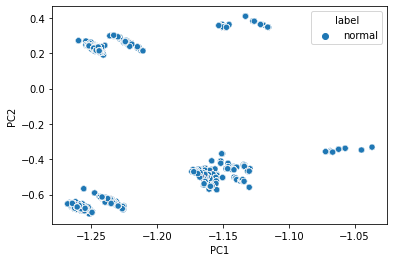

In [23]:
plot = df_pca.loc[df['tag'].isin(['normal'])]
sns.scatterplot(data=plot, x='PC1', y='PC2', hue=plot['label'])

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

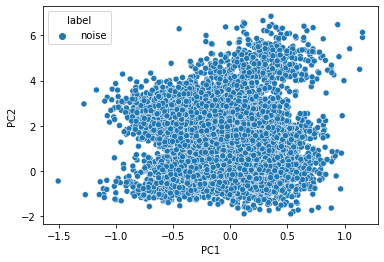

In [24]:
plot = df_pca.loc[df['tag'].isin(['noise'])]
sns.scatterplot(data=plot, x='PC1', y='PC2', hue=plot['label'])

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

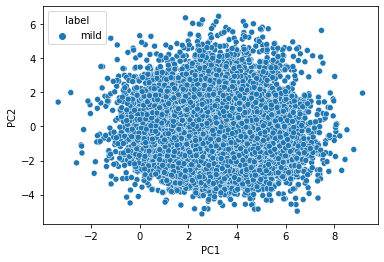

In [25]:
plot = df_pca.loc[df['tag'].isin(['mild'])]
sns.scatterplot(data=plot, x='PC1', y='PC2', hue=plot['label'])

# 2- Exploratory Data Analysis (EDA)

In [26]:
df[df['error']==False].describe()

,id,roll,pitch,yaw,heading,rollRate,pitchRate,yawRate,groundSpeed,climbRate,altitudeRelative,throttlePct
count,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000,33017.000000
mean,207.405155,0.000806,0.002833,0.844894,115.250263,0.000154,-0.000066,-0.000037,0.037203,-0.111073,-0.528727,0.012212
std,165.402414,0.008437,0.009592,0.762674,129.866613,0.001544,0.001591,0.001599,0.022983,0.082060,0.423008,0.036281
min,6.000000,-0.020466,-0.023518,-0.061491,0.000000,-0.004801,-0.004413,-0.004161,0.000375,-0.234207,-0.971000,0.000000
25%,66.000000,-0.005022,-0.004126,0.075876,0.080000,-0.000828,-0.001275,-0.001214,0.018749,-0.173954,-0.817000,0.000000
50%,134.000000,0.000648,0.002261,1.568556,85.260002,0.000223,-0.000081,-0.000036,0.033824,-0.138986,-0.756000,0.000000
75%,370.000000,0.007013,0.009642,1.570579,92.820000,0.001211,0.001067,0.000924,0.050225,-0.063068,0.024000,0.000000
max,514.000000,0.023513,0.027969,1.581190,359.989990,0.004769,0.005313,0.004973,0.128819,0.135915,0.361000,0.120000


In [27]:
df[df['error']==True].describe()

,id,roll,pitch,yaw,heading,rollRate,pitchRate,yawRate,groundSpeed,climbRate,altitudeRelative,throttlePct
count,26851.000000,26851.000000,26851.000000,26851.000000,26851.000000,26851.000000,26851.000000,26851.000000,26851.000000,26851.000000,26851.000000,26851.000000
mean,50.289449,-5.191411,-5.271968,-4.291541,130.159760,-2.894395,-2.843500,-2.893298,-0.060685,-0.031673,4.208453,0.658885
std,36.723424,8.175582,8.321292,8.263905,142.919600,4.062449,4.006260,4.043492,1.806620,0.597060,7.732427,0.368141
min,0.000000,-48.822454,-53.571869,-44.417768,-42.709561,-25.546001,-26.803217,-22.341813,-7.195456,-2.971231,-24.377808,-1.842067
25%,17.000000,-9.138330,-9.290264,-8.296445,0.229745,-4.612125,-4.505031,-4.595928,-1.027568,-0.191787,0.003183,0.510632
50%,43.000000,-1.698873,-1.712099,-0.949445,88.957910,-1.579908,-1.601555,-1.591066,-0.278749,-0.000324,3.586820,0.659364
75%,85.000000,-0.524382,-0.529838,0.592024,340.832798,-0.489292,-0.489390,-0.492563,0.861755,0.171113,8.638197,0.804529
max,114.000000,27.892036,32.098754,28.455867,386.732065,14.468151,13.926677,12.638765,7.696467,3.920846,47.895655,2.978167


In [28]:
df.pipe(shape)

Rows: 59868
   
Columns: 15


In [29]:
df.pipe(info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59868 entries, 0 to 59867
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                59868 non-null  int64  
 1   Type              59868 non-null  object 
 2   error             59868 non-null  bool   
 3   roll              59868 non-null  float64
 4   pitch             59868 non-null  float64
 5   yaw               59868 non-null  float64
 6   heading           59868 non-null  float64
 7   rollRate          59868 non-null  float64
 8   pitchRate         59868 non-null  float64
 9   yawRate           59868 non-null  float64
 10  groundSpeed       59868 non-null  float64
 11  climbRate         59868 non-null  float64
 12  altitudeRelative  59868 non-null  float64
 13  throttlePct       59868 non-null  float64
 14  tag               59868 non-null  object 
dtypes: bool(1), float64(11), int64(1), object(2)
memory usage: 6.5+ MB
None


In [30]:
df.pipe(nulls_qtd)

id                  0
Type                0
error               0
roll                0
pitch               0
yaw                 0
heading             0
rollRate            0
pitchRate           0
yawRate             0
groundSpeed         0
climbRate           0
altitudeRelative    0
throttlePct         0
tag                 0
dtype: int64


In [31]:
df[df["yaw"].isnull()]["id"].nunique()

0

In [32]:
df["yaw"] = df["yaw"].fillna(0)

<AxesSubplot:>

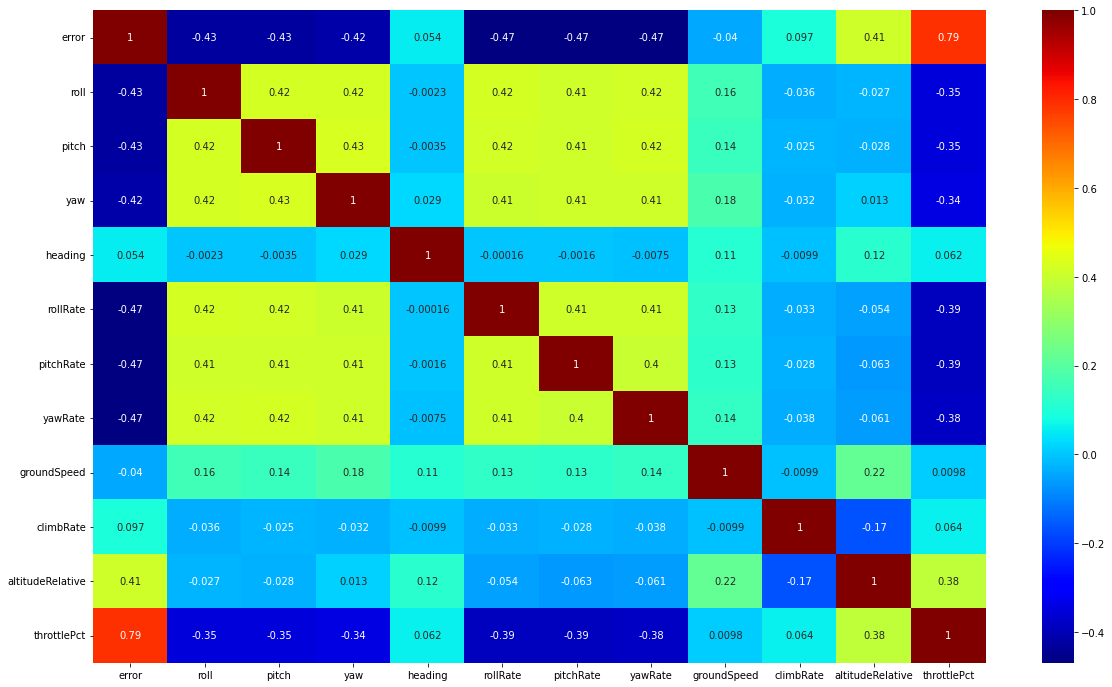

In [33]:
plt.figure(figsize=(20,12))
sns.heatmap(df.drop(['id'], axis=1).corr(), annot=True, cmap='jet')

# 3- Anomaly Detection (LSTM)

In [34]:
df_reduced = df.pipe(select_columns, ['roll', 'pitch', 'yaw', 'error'])
df_reduced.loc[:,'error'] = df_reduced['error'].astype(int)
df_reduced

/home/vannini/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,roll,pitch,yaw,error
0,-0.007304,0.002815,-0.058843,0
1,-0.007304,0.002815,-0.058843,0
2,-0.007304,0.002815,-0.058843,0
3,-0.007304,0.002815,-0.058843,0
4,-0.007304,0.002815,-0.058843,0
...,...,...,...,...
59863,-17.010648,11.710513,-3.284860,1
59864,-23.359250,-16.487313,-12.412916,1
59865,-16.644187,-5.523513,-11.430381,1
59866,-9.307633,-11.931500,-16.140397,1


In [35]:
#Preparing the data for LSTM model
data_n = df_reduced
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)
data_n = pd.DataFrame(np_scaled, columns=data_n.columns)
data_n

,roll,pitch,yaw,error
0,0.383349,0.384093,0.228692,-0.901802
1,0.383349,0.384093,0.228692,-0.901802
2,0.383349,0.384093,0.228692,-0.901802
3,0.383349,0.384093,0.228692,-0.901802
4,0.383349,0.384093,0.228692,-0.901802
...,...,...,...,...
59863,-2.425481,2.284906,-0.298293,1.108890
59864,-3.474225,-2.293175,-1.789402,1.108890
59865,-2.364945,-0.513138,-1.628900,1.108890
59866,-1.152998,-1.553513,-2.398303,1.108890


In [36]:
data_n.describe()

,roll,pitch,yaw,error
count,5.986800e+04,5.986800e+04,5.986800e+04,5.986800e+04
mean,-7.595833e-18,-6.076667e-17,-3.038333e-17,-6.076667e-17
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-7.680564e+00,-8.314069e+00,-7.017539e+00,-9.018025e-01
25%,1.538244e-01,1.540546e-01,1.469386e-01,-9.018025e-01
50%,3.836455e-01,3.828805e-01,2.533175e-01,-9.018025e-01
75%,3.852955e-01,3.847512e-01,4.947794e-01,1.108890e+00
max,4.992121e+00,5.595056e+00,4.886698e+00,1.108890e+00


In [37]:
df_pca_input = df.pipe(select_columns, ['roll','pitch','yaw','rollRate','pitchRate','yawRate','climbRate','groundSpeed'])

In [38]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(df_pca_input)
data_scaled_pca = pd.DataFrame(np_scaled)

In [39]:
pca = PCA(n_components = 3)
pca.fit(data_scaled_pca)

PCA(n_components=3)

In [40]:
df_pca = pca.transform(data_scaled_pca)


# LSTM Model - Pitch/Row/Yaw

In [41]:
x = data_n.drop(['error'],axis=1)
y = data_n.error

print(x.head())
print('\n\n')
print(y.head())

       roll     pitch       yaw
0  0.383349  0.384093  0.228692
1  0.383349  0.384093  0.228692
2  0.383349  0.384093  0.228692
3  0.383349  0.384093  0.228692
4  0.383349  0.384093  0.228692



0   -0.901802
1   -0.901802
2   -0.901802
3   -0.901802
4   -0.901802
Name: error, dtype: float64


In [42]:
# from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=33)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(44901, 3)
(44901,)
(14967, 3)
(14967,)


In [43]:
x_test

,roll,pitch,yaw
23564,0.384455,0.383788,0.494728
48824,-1.694922,-2.812501,-0.826682
36627,0.027963,0.196307,0.155969
49796,-1.290200,-1.097372,-2.067456
19310,0.383158,0.384005,0.494847
...,...,...,...
50634,0.181202,1.653623,-0.755525
27911,0.383778,0.382530,0.495012
19654,0.384401,0.383249,0.494877
55058,-1.965199,-1.552111,-2.002914


In [44]:
# Convert X_train and X_test to NumPy arrays
x_train = x_train.values
x_test = x_test.values

# Reshape your input data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Reshape y_train
y_train = np.array(y_train)
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# Reshape y_test
y_test = np.array(y_test)
y_test = np.reshape(y_test, (y_test.shape[0], 1))

In [45]:
sz = x_train.shape[0] + x_test.shape[0]

print(f'Train relation: {(x_train.shape[0]/sz)*100}% of the data')
print(f'Test relation: {(x_test.shape[0]/sz)*100}% of the data')

Train relation: 75.0% of the data
Test relation: 25.0% of the data


In [46]:
#Building the model
model = Sequential()


model.add(LSTM(360, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.03840756416320801


In [47]:
model.fit(x_train, y_train, batch_size=60, epochs=30, validation_split=0.1)

Epoch 1/30
674/674 [==============================] - 18s 23ms/step - loss: 0.3156 - val_loss: 0.0916
Epoch 2/30
674/674 [==============================] - 18s 26ms/step - loss: 0.0661 - val_loss: 0.0397
Epoch 3/30
674/674 [==============================] - 17s 25ms/step - loss: 0.0409 - val_loss: 0.1655
Epoch 4/30
674/674 [==============================] - 16s 24ms/step - loss: 0.0320 - val_loss: 0.0238
Epoch 5/30
674/674 [==============================] - 16s 24ms/step - loss: 0.0265 - val_loss: 0.0186
Epoch 6/30
674/674 [==============================] - 16s 24ms/step - loss: 0.0225 - val_loss: 0.0150
Epoch 7/30
674/674 [==============================] - 16s 24ms/step - loss: 0.0199 - val_loss: 0.0139
Epoch 8/30
674/674 [==============================] - 16s 24ms/step - loss: 0.0182 - val_loss: 0.0508
Epoch 9/30
674/674 [==============================] - 16s 23ms/step - loss: 0.0169 - val_loss: 0.0118
Epoch 10/30
674/674 [==============================] - 15s 23ms/step - loss: 0.015

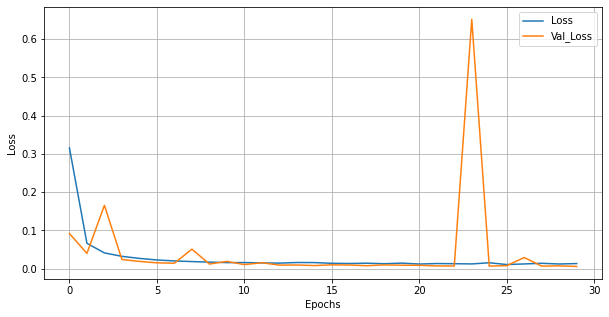

In [48]:
#Visualizing training and validaton loss
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], label = 'Val_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

In [49]:
y_pred = model.predict(x_test)

In [50]:
type(x_test)

numpy.ndarray

In [51]:
threshold = 0
softmax_pred = np.where(y_pred[:, 0] >= threshold, 1, 0)

In [52]:
softmax_test = np.where(y_test[:, 0] >= threshold, 1, 0)

In [53]:
data_n.groupby('error').size().reset_index(name='count')

,error,count
0,-0.901802,33017
1,1.108890,26851


In [54]:
df.groupby('error').size().reset_index(name='count')

,error,count
0,False,33017
1,True,26851


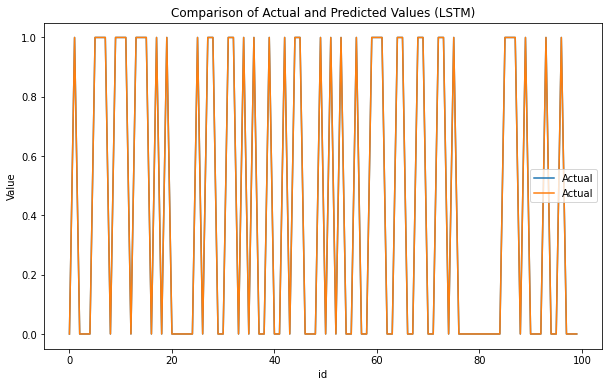

In [55]:
# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.plot(softmax_pred[500:600], label='Actual')
plt.plot(softmax_test[500:600], label='Actual')
# plt.plot(y_test[500:600], label='Actual')
# plt.plot(y_pred[500:600], label='Predicted')
plt.xlabel('id')
plt.ylabel('Value')
plt.title('Comparison of Actual and Predicted Values (LSTM)')
plt.legend()
plt.show()

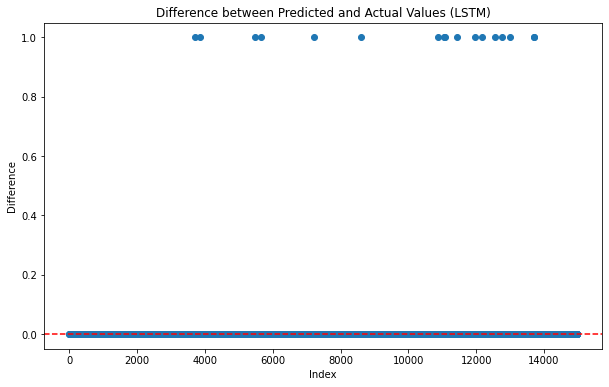

In [56]:
# Calculate the difference between predicted and actual values
difference = softmax_test - softmax_pred

# Plotting the difference as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(difference)), difference)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Index')
plt.ylabel('Difference')
plt.title('Difference between Predicted and Actual Values (LSTM)')
plt.show()

In [57]:
np.sum(np.abs(difference))/len(difference)*100

0.11358321640943408

In [58]:
# ser'a q os erros estao muito suaves? ou muito absurdos?
## procurar base na internet com erro de pitch, roll e yaw

In [59]:
len(difference)

14967

In [60]:
df.groupby('error').count()

,id,Type,roll,pitch,yaw,heading,rollRate,pitchRate,yawRate,groundSpeed,climbRate,altitudeRelative,throttlePct,tag
error,,,,,,,,,,,,,,
False,33017,33017,33017,33017,33017,33017,33017,33017,33017,33017,33017,33017,33017,33017
True,26851,26851,26851,26851,26851,26851,26851,26851,26851,26851,26851,26851,26851,26851


In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 360)               521280    
_________________________________________________________________
dropout (Dropout)            (None, 360)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 361       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 521,641
Trainable params: 521,641
Non-trainable params: 0
_________________________________________________________________


> Exporting Model

In [66]:
import tensorflow as tf

In [68]:
filename = "LSTM_predictions_new.pkl"
tf.keras.models.save_model(model, filename)

INFO:tensorflow:Assets written to: LSTM_predictions_new.pkl/assets


INFO:tensorflow:Assets written to: LSTM_predictions_new.pkl/assets


In [69]:
# loaded_LSTM = joblib.load(filename)
loaded_LSTM = tf.keras.models.load_model(filename)

In [83]:
data_n.drop(columns=['error'],axis=1).values

array([[ 0.38334928,  0.38409291,  0.22869159],
       [ 0.38334928,  0.38409291,  0.22869159],
       [ 0.38334928,  0.38409291,  0.22869159],
       ...,
       [-2.36494472, -0.51313848, -1.62890027],
       [-1.15299849, -1.55351255, -2.3983027 ],
       [-4.22204756, -2.6796179 , -2.65020408]])

In [87]:
teste[0]

array([[0.38334928],
       [0.38409291],
       [0.22869159]])

In [ ]:
0.00886934157460928
-0.0028823059983551502
-1.6777632236480713
0.027789655395474615
-0.04991879137122454
-3.307650242857489


In [85]:
teste = data_n.drop(columns=['error'],axis=1).values[0]

# Reshape your input data
teste = teste.reshape((teste.shape[0], teste.shape[1], 1))

In [105]:
test = [[[0.00886934157460928],[-0.0028823059983551502],[-1.6777632236480713]]]

In [106]:
y_pred = model.predict(test)

In [107]:
teste[0]

array([[0.38334928],
       [0.38409291],
       [0.22869159]])

In [100]:
teste[0:1]

array([[[0.38334928],
        [0.38409291],
        [0.22869159]]])

In [108]:
y_pred

array([[1.0776055]], dtype=float32)

In [109]:
threshold = 0
softmax_pred = np.where(y_pred[:, 0] >= threshold, 1, 0)

In [113]:
softmax_pred

array([1])

In [110]:
softmax_test = np.where(data_n["error"].values >= threshold, 1, 0)

In [111]:
difference = softmax_test - softmax_pred

In [112]:
(np.sum(difference)/len(difference))*100

-55.14966259103361